# Imports

In [71]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.cluster import KMeans

# Config

In [2]:
INPUT_PATH = 'ride_data/'
OUTPUT_PATH = 'data/pair_labels.parquet'
START_DATE = '2023-01-01'
END_DATE = '2023-04-30'

# Loading Dataset

In [3]:
def load_data(path, start_date: str, end_date: str):
    df = pd.read_parquet(path) 
    start_date = datetime.date.fromisoformat(start_date)
    end_date = datetime.date.fromisoformat(end_date)
    filtered_df = df[(df['tpep_pickup_datetime'].dt.date >= start_date) &
                     (df['tpep_pickup_datetime'].dt.date <= end_date)]
    dataset = filtered_df.filter(items=['tpep_pickup_datetime', 'PULocationID', 'DOLocationID'])
    dataset['PU_date'] = pd.to_datetime(dataset['tpep_pickup_datetime'].dt.date)
    return dataset

In [4]:
rides_df = load_data(INPUT_PATH, START_DATE, END_DATE)
print(f'rides_df shape : {rides_df.shape}')
rides_df.head()

rides_df shape : (12672629, 4)


,tpep_pickup_datetime,PULocationID,DOLocationID,PU_date
0,2023-01-01 00:32:10,161,141,2023-01-01
1,2023-01-01 00:55:08,43,237,2023-01-01
2,2023-01-01 00:25:04,48,238,2023-01-01
3,2023-01-01 00:03:48,138,7,2023-01-01
4,2023-01-01 00:10:29,107,79,2023-01-01


# Labeling

In [5]:
def labeling(dataset):
    dataset_labels = (
        dataset
        .groupby(['PULocationID', 'DOLocationID', 'PU_date'])['PU_date']
        .count()
        .to_frame('Demand')
        .sort_values(['PULocationID', 'DOLocationID', 'PU_date'], ascending=[True, True, True])
        .reset_index()
        .rename(columns={'PULocationID': 'PULocation', 'DOLocationID': 'DOLocation', 'PU_date': 'Date'})
    )
  
    pu_locations = pd.DataFrame(dataset_labels['PULocation'].unique(), columns=['PULocation'])
    do_locations = pd.DataFrame(dataset_labels['DOLocation'].unique(), columns=['DOLocation'])
    dates = pd.DataFrame(dataset_labels['Date'].unique(), columns=['Date'])
    
    location_date_df = (
        pu_locations
        .merge(dates, how='cross')
        .merge(do_locations, how = 'cross')
        .sort_values(['PULocation', 'DOLocation', 'Date'], ascending=[True, True, True])
        .reset_index(drop=True)
    )
    
    labels_df = (
        location_date_df
        .merge(dataset_labels, how='left', on=['PULocation', 'DOLocation', 'Date'])
        .fillna(value=0)
    )
    
    return labels_df

In [14]:
labels_df = labeling(rides_df)
print(f'labels_df shape : {labels_df.shape}')
labels_df.head()

labels_df shape : (8205840, 4)


,PULocation,Date,DOLocation,Demand
0,1,2023-01-01,1,37.0
1,1,2023-01-02,1,29.0
2,1,2023-01-03,1,25.0
3,1,2023-01-04,1,6.0
4,1,2023-01-05,1,11.0


In [15]:
mean_labeled_df = (labels_df.groupby(['PULocation', 'DOLocation'], as_index=False)['Demand']
                   .mean().sort_values('Demand', ascending=False)
                   .reset_index(drop=True))

In [60]:
def plot_cumsum_demand(labeled_df, target_demand):
    grouped_df = (labeled_df.groupby(['PULocation', 'DOLocation'], as_index=False)['Demand']
                  .sum().reset_index().sort_values(by='Demand', ascending=False).reset_index(drop=True))
    cumulative_demand = (grouped_df['Demand'].cumsum() / grouped_df['Demand'].sum()).to_numpy()
    
    plt.plot(range(0,len(cumulative_demand)), cumulative_demand)
    plt.xlabel('Location numbers')
    plt.ylabel('Cumulative Demand')
    plt.title('Cumulative Demand by Location')
    target_x = (cumulative_demand <= target_demand).argmin()
    plt.axhline(y=target_demand, color='r', linestyle='--', label=f'Target Demand ({target_demand})')
    plt.axvline(x=target_x, color='g', linestyle='--', label=f'Target Location ({target_x})')
    important_pairs = grouped_df.iloc[:target_x][['PULocation', 'DOLocation']]
    
    plt.legend() 
    plt.show()
    return target_x, important_pairs

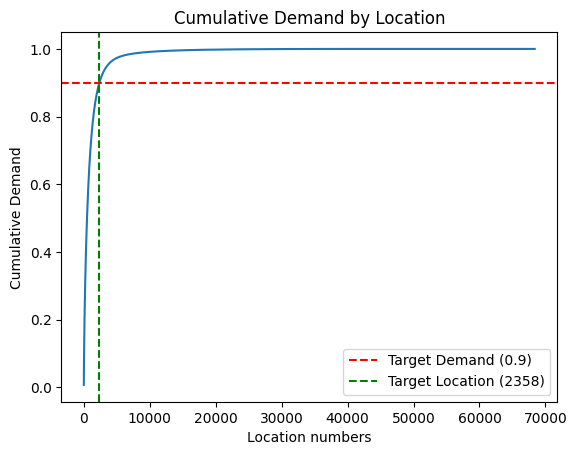

In [90]:
last_pair_index, important_pairs = plot_cumsum_demand(labels_df, 0.90)

In [ ]:
unique_locations = important_pairs['PULocation'].unique()

fig, axes = plt.subplots(len(unique_locations), 1, figsize=(8, 6 * len(unique_locations)))

# Iterate over unique locations and create separate plots
for i, location in enumerate(unique_locations):
    # Create a directed graph for the specific location
    G = nx.DiGraph()

    location_df = important_pairs[important_pairs['PULocation'] == location]

    # Add nodes and edges to the graph
    for _, row in location_df.iterrows():
        source, target = row['PULocation'], row['DOLocation']
        G.add_edge(source, target)

    pos = nx.spring_layout(G, k=0.3)

    nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', node_size=200, font_size=7, alpha=0.8, arrows=True, ax=axes[i])

    axes[i].set_title(f'Pairs Visualization - PULocation: {location}, {len(location_df)} pairs')
    axes[i].axis('off')

plt.tight_layout()

plt.show()

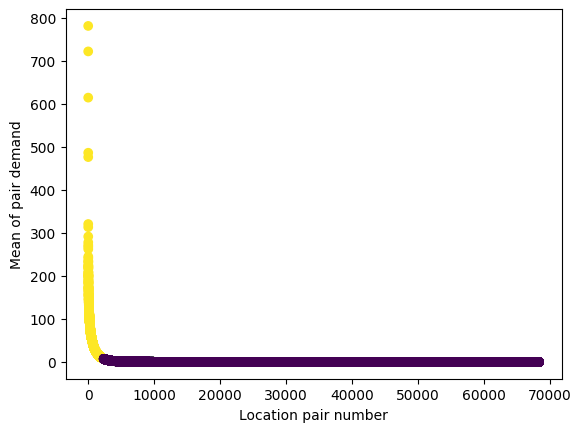

In [63]:
pair_labels = np.concatenate((np.ones(last_pair_index), np.zeros(len(mean_labeled_df) - last_pair_index)))
plt.scatter(range(len(mean_labeled_df['Demand'].values)), mean_labeled_df['Demand'].values, c = pair_labels)
plt.xlabel('Location pair number')
plt.ylabel('Mean of pair demand')
plt.show()

In [64]:
merged_df = pd.merge(labels_df, important_pairs, on=['PULocation', 'DOLocation'], how='inner')

In [66]:
print(f'labels_df shape : {merged_df.shape}')
merged_df.head()

labels_df shape : (282960, 4)


,PULocation,Date,DOLocation,Demand
0,1,2023-01-01,1,37.0
1,1,2023-01-02,1,29.0
2,1,2023-01-03,1,25.0
3,1,2023-01-04,1,6.0
4,1,2023-01-05,1,11.0


In [67]:
merged_df[merged_df['Demand'] == 0]

,PULocation,Date,DOLocation,Demand
171,4,2023-02-21,79,0.0
200,4,2023-03-22,79,0.0
1016,13,2023-02-26,88,0.0
1242,13,2023-02-12,100,0.0
1256,13,2023-02-26,100,0.0
...,...,...,...,...
282677,264,2023-03-19,239,0.0
282684,264,2023-03-26,239,0.0
282703,264,2023-04-14,239,0.0
282708,264,2023-04-19,239,0.0


# File saving

In [90]:
def save_labels(dataset, path):
    labels_df = dataset.to_parquet(path, index=False)

In [91]:
save_labels(merged_df, OUTPUT_PATH)